# Quantitative Finance Model using Donadio and Ghosh Learn Algorithmic Trading Chapter 4 Turtle Trading Example
### David Lowe
### August 22, 2022

NOTE: This script is for learning purposes only and does not constitute a recommendation for buying or selling any stock mentioned in this script.

SUMMARY: This project aims to construct and test an algorithmic trading model and document the end-to-end steps using a template.

INTRODUCTION: This script aims to replicate the Turtle Trading example found in chapter three of the book Learn Algorithmic Trading by Sebastien Donadio and Sourav Ghosh. The script seeks to validate the Python environment and package requirements for running these code examples successfully. The eventual goal is to integrate various example code segments from the book into an end-to-end algorithmic trading system.

Dataset ML Model: Time series analysis with numerical attributes

Dataset Used: Sharadar US Equities and Fund Prices from Quandl/Nasdaq Data Link

Source and Further Discussion of the Code Examples: https://github.com/PacktPublishing/Learn-Algorithmic-Trading

# Task 1 - Prepare Environment

## 1.a) Load the required packages and modules

In [1]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

## 1.b) Set up the controlling parameters and functions

In [2]:
# Specify the key modeling parameters below
DATA_STORE = '../sharadar.h5'
ticker_symbol = 'GOOGL'

WINDOW_SIZE = 50

MODEL_START_DATE = date(2014, 1, 1)
print("Starting date for the model:", MODEL_START_DATE)

# MODEL_END_DATE = datetime.now().date()
MODEL_END_DATE = date(2018, 12, 31)
print("Ending date for the model:", MODEL_END_DATE)

Starting date for the model: 2014-01-01
Ending date for the model: 2018-12-31


# Task 2 - Acquire and Pre-Process Data

## Instead of using pandas-datareader like in the book example, this script will use another commercial data source.

In [3]:
with pd.HDFStore(DATA_STORE) as store:
    goog_data = (store['quandl/sharadar/sep'].loc[[ticker_symbol], ['open', 'high', 'low', 'close', 'volume']])
goog_data.reset_index(level=0, inplace=True)
goog_data.sort_index(inplace=True)
goog_data = goog_data[MODEL_START_DATE:MODEL_END_DATE]
goog_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2014-01-02 to 2018-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  1258 non-null   object 
 1   open    1258 non-null   float64
 2   high    1258 non-null   float64
 3   low     1258 non-null   float64
 4   close   1258 non-null   float64
 5   volume  1258 non-null   float64
dtypes: float64(5), object(1)
memory usage: 68.8+ KB


# Task 3 - Set up the Helper Functions for Modeling

In [4]:
def turtle_trading(financial_data, window_size):
    signals = pd.DataFrame(index=financial_data.index)
    signals['orders'] = 0
    # window_size-days high
    signals['high'] = financial_data['close'].shift(1).\
        rolling(window=window_size).max()
    # window_size-days low
    signals['low'] = financial_data['close'].shift(1).\
        rolling(window=window_size).min()
    # window_size-days mean
    signals['avg'] = financial_data['close'].shift(1).\
        rolling(window=window_size).mean()

    # entry rule : stock price > the higest value for window_size day
    #              stock price < the lowest value for window_size day

    signals['long_entry'] = financial_data['close'] > signals.high
    signals['short_entry'] = financial_data['close'] < signals.low

    #exit rule : the stock price crosses the mean of past window_size days.

    signals['long_exit'] = financial_data['close'] < signals.avg
    signals['short_exit'] = financial_data['close'] > signals.avg

    init=True
    position = 0
    for k in range(len(signals)):
        if signals['long_entry'][k] and position==0:
            signals.orders.values[k] = 1
            position = 1
        elif signals['short_entry'][k] and position==0:
            signals.orders.values[k] = -1
            position = -1
        elif signals['short_exit'][k] and position>0:
            signals.orders.values[k] = -1
            position = 0
        elif signals['long_exit'][k] and position < 0:
            signals.orders.values[k] = 1
            position = 0
        else:
            signals.orders.values[k] = 0

    return signals

In [5]:
def plot_chart(asset_price, trade_strategy):
    fig = plt.figure(figsize=(16, 10))
    ax1 = fig.add_subplot(111, ylabel='Google price in $')
    asset_price["close"].plot(ax=ax1, color='g', lw=.5)
    trade_strategy["high"].plot(ax=ax1, color='g', lw=.5)
    trade_strategy["low"].plot(ax=ax1, color='r', lw=.5)
    trade_strategy["avg"].plot(ax=ax1, color='b', lw=.5)


    ax1.plot(ts.loc[ts.orders== 1.0].index,
             goog_data["close"][trade_strategy.orders == 1.0],
             '^', markersize=7, color='k')

    ax1.plot(ts.loc[ts.orders== -1.0].index,
             goog_data["close"][trade_strategy.orders == -1.0],
             'v', markersize=7, color='k')
    #
    # ax1.plot(ts.loc[ts.long_entry == True].index,
    #          goog_data["Adj Close"][ts.long_entry== True],
    #          '^', markersize=7, color='k')
    #
    # ax1.plot(ts.loc[ts.short_entry == True].index,
    #          goog_data["Adj Close"][ts.short_entry== True],
    #          'v', markersize=7, color='k')
    #
    # ax1.plot(ts.loc[ts.long_exit == True].index,
    #          goog_data["Adj Close"][ts.long_exit == True],
    #          'v', markersize=7, color='k')
    #
    # ax1.plot(ts.loc[ts.short_exit == True].index,
    #          goog_data["Adj Close"][ts.short_exit == True],
    #          'v', markersize=7, color='k')

    plt.legend(["Price","Highs","Lows","Average","Buy","Sell"])
    plt.title("Turtle Trading Strategy")

    plt.show()

In [6]:
def calculate_portfolio(financial_data, trade_strategy):
    # You are going to set your initial amount of money you want
    # to invest --- here it is 10,000
    initial_capital = float(10000.0)

    # You are going to create a new dataframe positions
    # Remember the index is still the same as signals
    positions = pd.DataFrame(index=trade_strategy.index).fillna(0.0)

    # You are going to buy 10 shares of MSFT when signal is 1
    # You are going to sell 10 shares of MSFT when signal is -1
    # You will assign these values to the column MSFT of the
    # dataframe positions
    positions['GOOGL'] = 10 * trade_strategy['orders']

    # You are now going to calculate the notional (quantity x price)
    # for your portfolio. You will multiply Adj Close from
    # the dataframe containing prices and the positions (10 shares)
    # You will store it into the variable portfolio
    portfolio = positions.multiply(financial_data['close'], axis=0)

    # Add `holdings` to portfolio
    portfolio['holdings'] = (positions.multiply(financial_data['close'], axis=0)).sum(axis=1)

    # You will store positions.diff into pos_diff
    pos_diff = positions.diff()
    # You will now add a column cash in your dataframe portfolio
    # which will calculate the amount of cash you have
    # initial_capital - (the notional you use for your different buy/sell)
    portfolio['cash'] = initial_capital - (pos_diff.multiply(financial_data['close'], axis=0)).sum(axis=1).cumsum()

    # You will now add a column total to your portfolio calculating the part of holding
    # and the part of cash
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']

    # Add `returns` to portfolio
    portfolio['returns'] = portfolio['total'].pct_change()

    # Print the first lines of `portfolio`
    print(portfolio)

# Task 4 - Build Model

In [7]:
ts = turtle_trading(goog_data, WINDOW_SIZE)

# Task 5 - Evaluate Model Performance

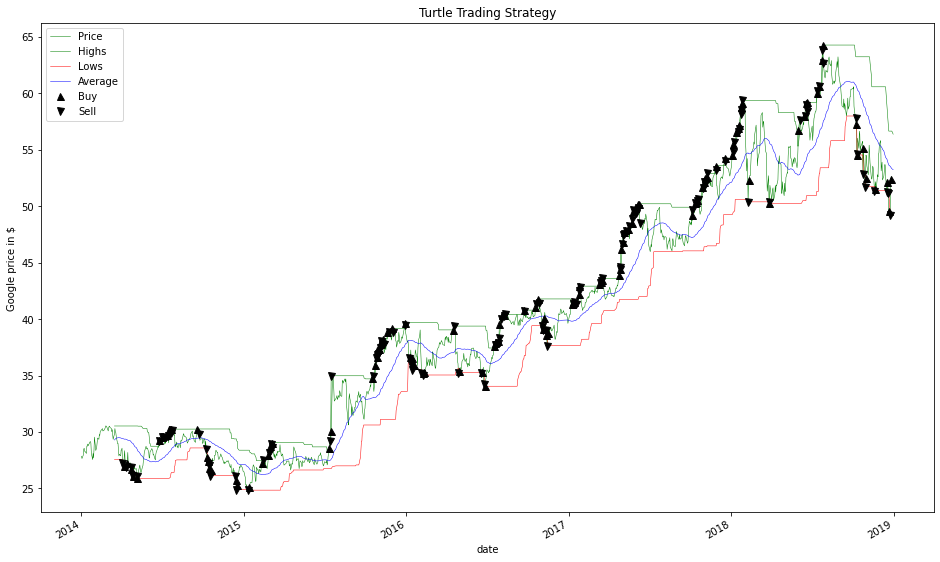

In [8]:
plot_chart(goog_data, ts)

In [9]:
calculate_portfolio(goog_data, ts)

             GOOGL  holdings      cash     total   returns
date                                                      
2014-01-02    0.00      0.00  10000.00  10000.00       NaN
2014-01-03    0.00      0.00  10000.00  10000.00  0.000000
2014-01-06    0.00      0.00  10000.00  10000.00  0.000000
2014-01-07    0.00      0.00  10000.00  10000.00  0.000000
2014-01-08    0.00      0.00  10000.00  10000.00  0.000000
...            ...       ...       ...       ...       ...
2018-12-24 -492.33   -492.33  10494.14  10001.81 -0.000329
2018-12-26  523.92    523.92   9446.30   9970.22 -0.003158
2018-12-27    0.00      0.00   9972.75   9972.75  0.000254
2018-12-28    0.00      0.00   9972.75   9972.75  0.000000
2018-12-31    0.00      0.00   9972.75   9972.75  0.000000

[1258 rows x 5 columns]
